In [1]:
import pandas as pd
import numpy as np
import os, chardet, glob
import matplotlib.pyplot as plt
import seaborn

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras import Sequential, optimizers, losses, layers

%matplotlib inline


In [2]:
df_overview = pd.read_excel('../input/battery-and-heating-data-in-real-driving-cycles/Overview.xlsx')
df_overview = df_overview.drop(['Unnamed: 13','Note'], axis=1)
df_overview = df_overview.dropna()
df_overview.rename(columns = {'Unnamed: 8':'SoC difference'}, inplace = True)
df_overview.head()


,Trip,Date,Route/Area,Weather,Battery Temperature (Start) [°C],Battery Temperature (End),Battery State of Charge (Start),Battery State of Charge (End),SoC difference,Ambient Temperature (Start) [°C],Target Cabin Temperature,Distance [km],Duration [min],Fan
0,TripA01,2019-06-25_13-21-14,Munich East,sunny,21.0,22.0,0.863,0.803,0.060,25.5,23.0,7.427690,16.820000,"Automatic, Level 1"
1,TripA02,2019-06-25_14-05-31,Munich East,sunny,23.0,26.0,0.803,0.673,0.130,32.0,23.0,23.509709,23.550000,"Automatic, Level 1"
2,TripA03,2019-06-28_10-02-15,Munich East,sunny,24.0,25.0,0.835,0.751,0.084,21.5,27.0,12.820846,11.180000,"Automatic, Level 1"
3,TripA04,2019-06-28_10-13-30,Munich East,sunny,25.0,27.0,0.751,0.667,0.084,24.0,22.0,10.727491,6.870000,"Automatic, Level 1"
4,TripA05,2019-06-28_10-20-26,Munich East,sunny,27.0,27.0,0.667,0.602,0.065,24.5,24.0,12.393223,22.776667,"Automatic, Level 1"


In [3]:
def combine_csvs():
    df_master = pd.DataFrame()
    for filename in glob.glob('../input/battery-and-heating-data-in-real-driving-cycles'+'*.csv'):
        df_trip = pd.read_csv(
            filename,
            sep=';',
            encoding=chardet.detect(open(filename, 'rb').read())['encoding']
        )
        df_master = pd.concat([df_master, df_trip])
        df_master.to_csv('../input/battery-and-heating-data-in-real-driving-cycles/AllTrips.csv', index=False)
    return df_master


def plot_dataframe_subplots(df, nrows, ncols, figsize=(30, 24)):
    measurements = list(df.columns)
    plt.figure(figsize=figsize)
    for idx, key in enumerate(measurements):
        plt.subplot(nrows, ncols, idx+1)
        plt.plot(np.array(range(df.shape[0]))*0.1, df[key])
        plt.ylabel(key)
        plt.grid(True)
        plt.xlabel(measurements[0])
        plt.show


DELETE THE CELL BELOW


In [4]:
if os.path.exists('./datasets/battery_heating/AllTrips.csv'):
    df_master = pd.read_csv('./datasets/ battery_heating/AllTrips.csv')
else: df_master = combine_csvs()

# Remove last 2 columns since they are Nan
df_master = df_master.iloc[: , :-2]
print(list(df_master.columns.values))


[]


In [5]:
# Load in the dataset
import os
import glob
import chardet 
import pandas as pd
df_master = pd.DataFrame()
for file_name in glob.glob('../input/battery-and-heating-data-in-real-driving-cycles/'+'*.csv'):
    rawdata = open(file_name, 'rb').read()
    result = chardet.detect(rawdata)
    charenc = result['encoding']
    df_trip = pd.read_csv(file_name, sep = ';',encoding = charenc)
    df_master = df_master.append(df_trip)

df_master = df_master.iloc[: , :-2]
print(list(df_master.columns.values))


['Time [s]', 'Velocity [km/h]', 'Elevation [m]', 'Throttle [%]', 'Motor Torque [Nm]', 'Longitudinal Acceleration [m/s^2]', 'Regenerative Braking Signal ', 'Battery Voltage [V]', 'Battery Current [A]', 'Battery Temperature [°C]', 'max. Battery Temperature [°C]', 'SoC [%]', 'displayed SoC [%]', 'min. SoC [%]', 'max. SoC [%)', 'Heating Power CAN [kW]', 'Heating Power LIN [W]', 'Requested Heating Power [W]', 'AirCon Power [kW]', 'Heater Signal', 'Heater Voltage [V]', 'Heater Current [A]', 'Ambient Temperature [°C]', 'Ambient Temperature Sensor [°C]', 'Coolant Temperature Heatercore [°C]', 'Requested Coolant Temperature [°C]', 'Coolant Temperature Inlet [°C]', 'Coolant Volume Flow +500 [l/h]', 'Heat Exchanger Temperature [°C]', 'Cabin Temperature Sensor [°C]', 'Temperature Coolant Heater Inlet [°C]', 'Temperature Coolant Heater Outlet [°C]', 'Temperature Heat Exchanger Outlet [°C]', 'Temperature Defrost lateral left [°C]', 'Temperature Defrost lateral right [°C]', 'Temperature Defrost centr

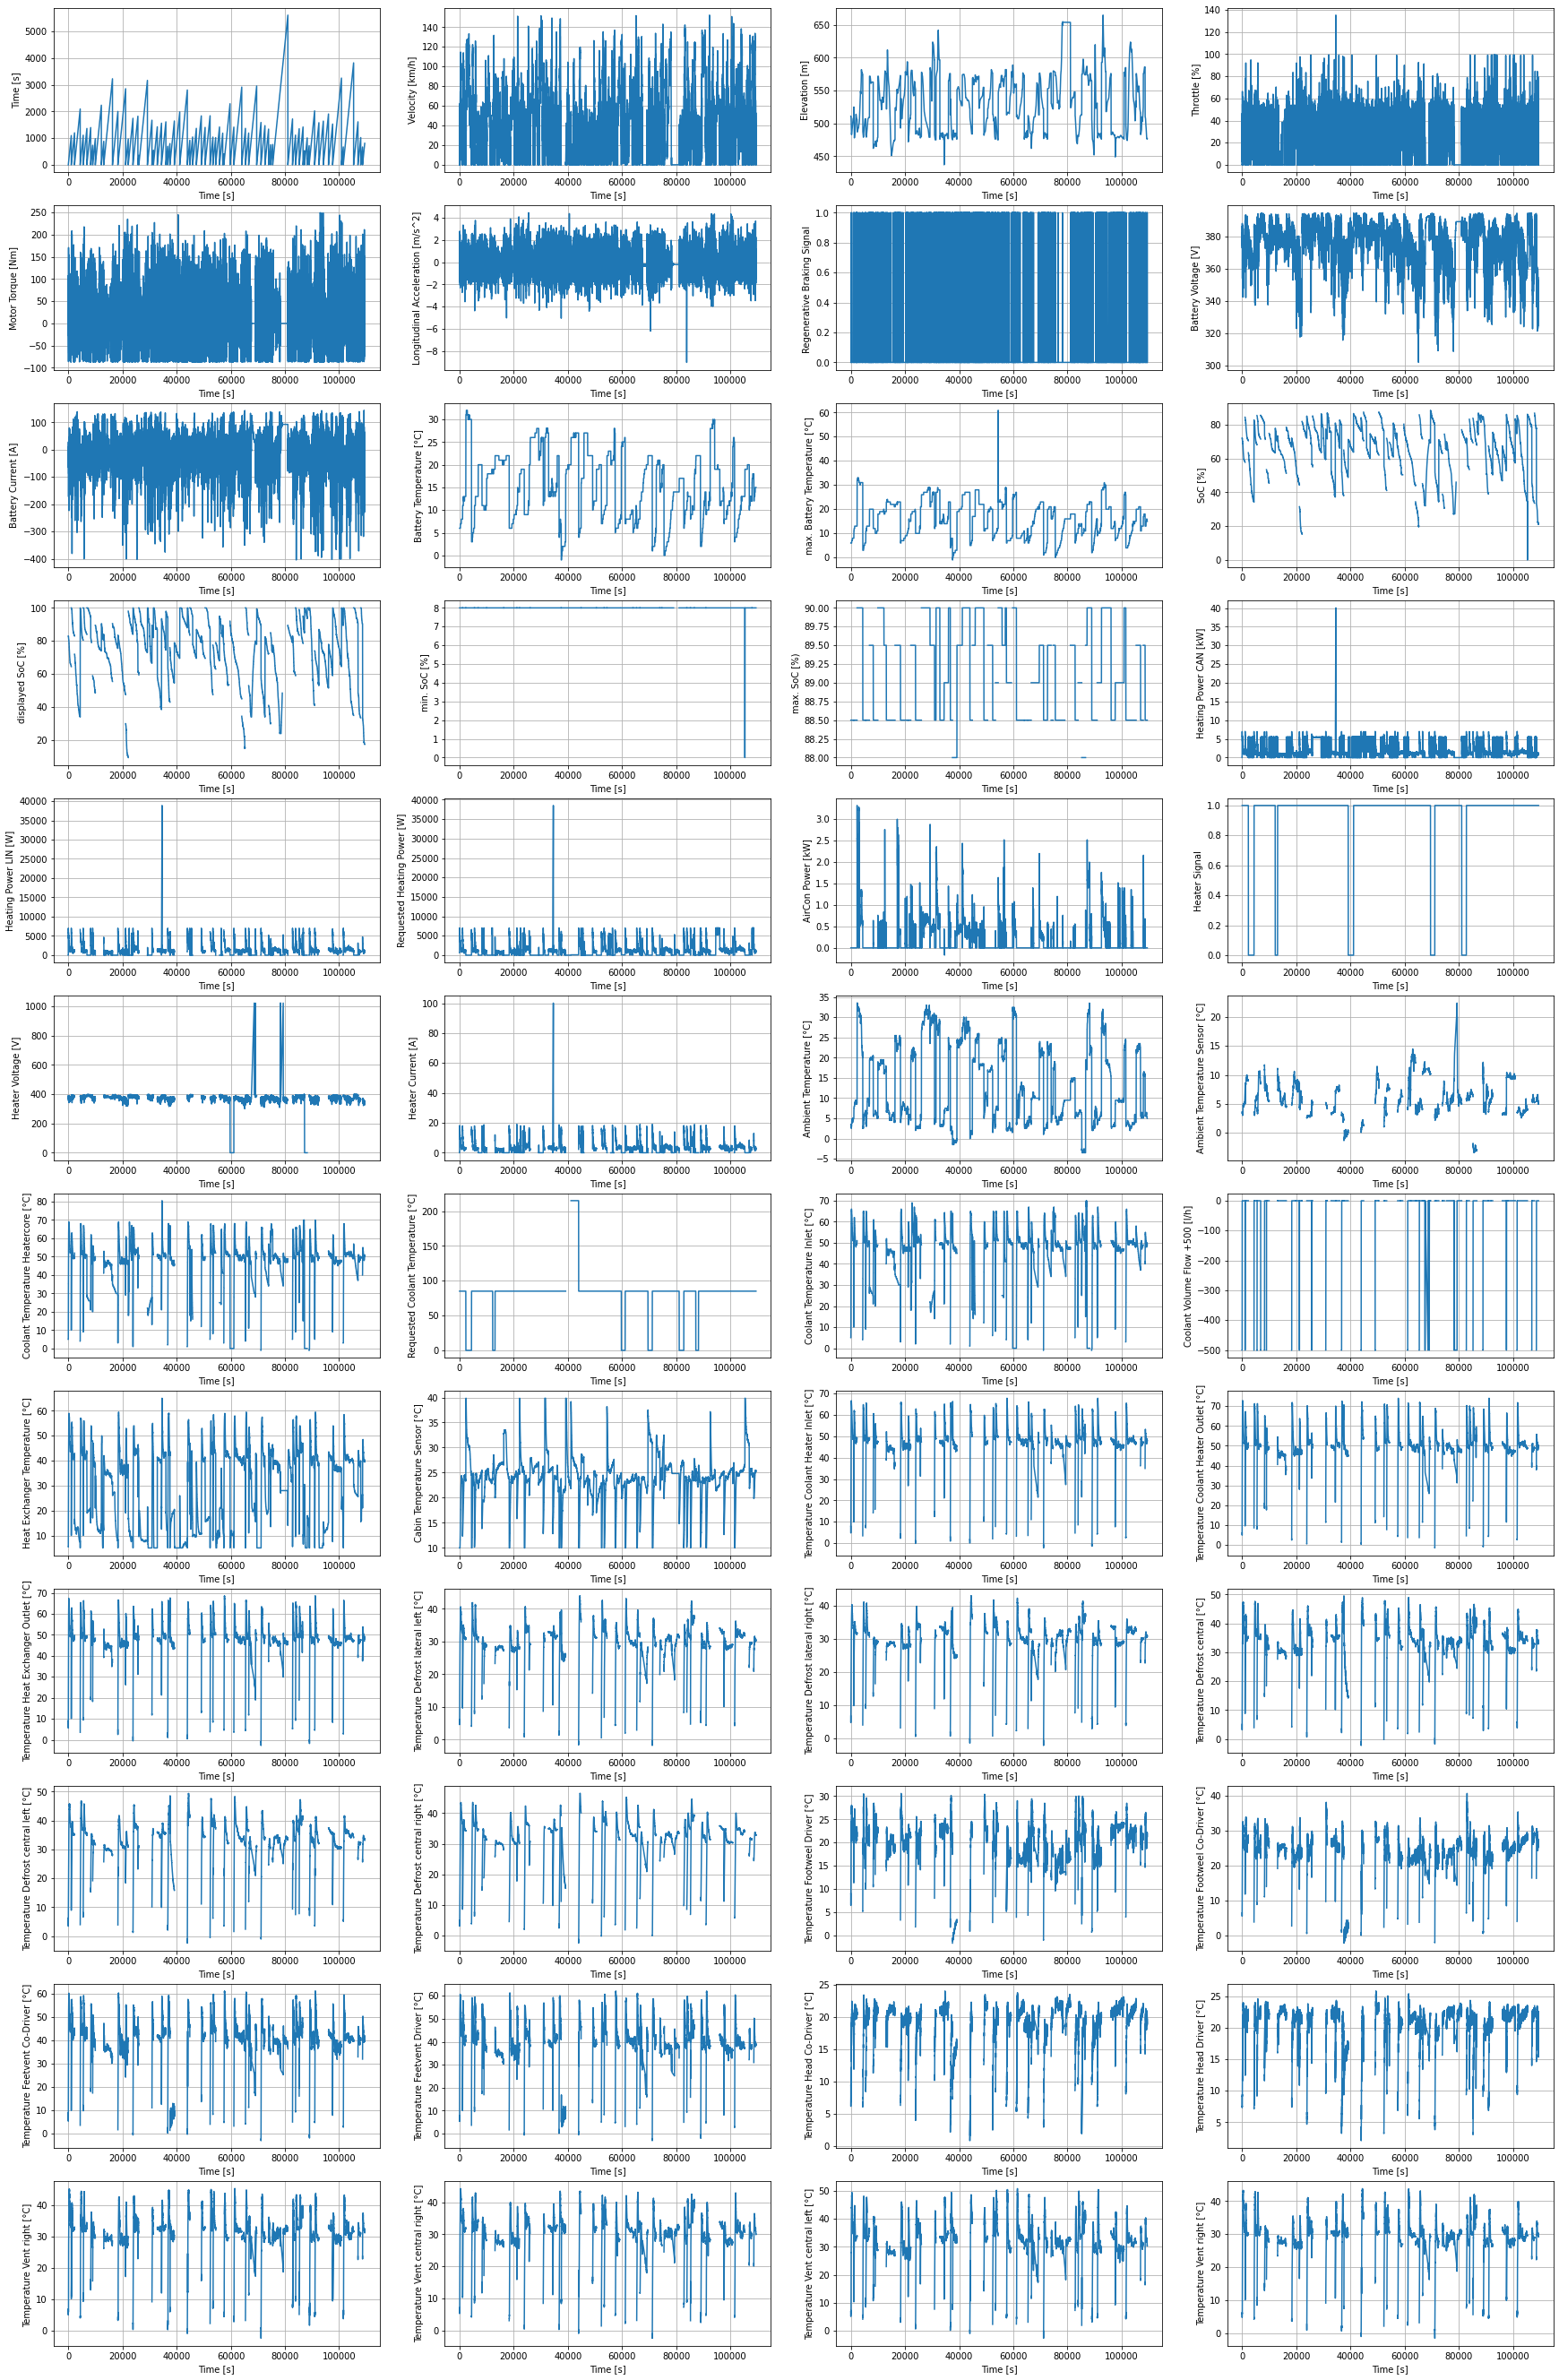

In [6]:
plot_dataframe_subplots(df_master, nrows=12, ncols=4, figsize=(30, 48))


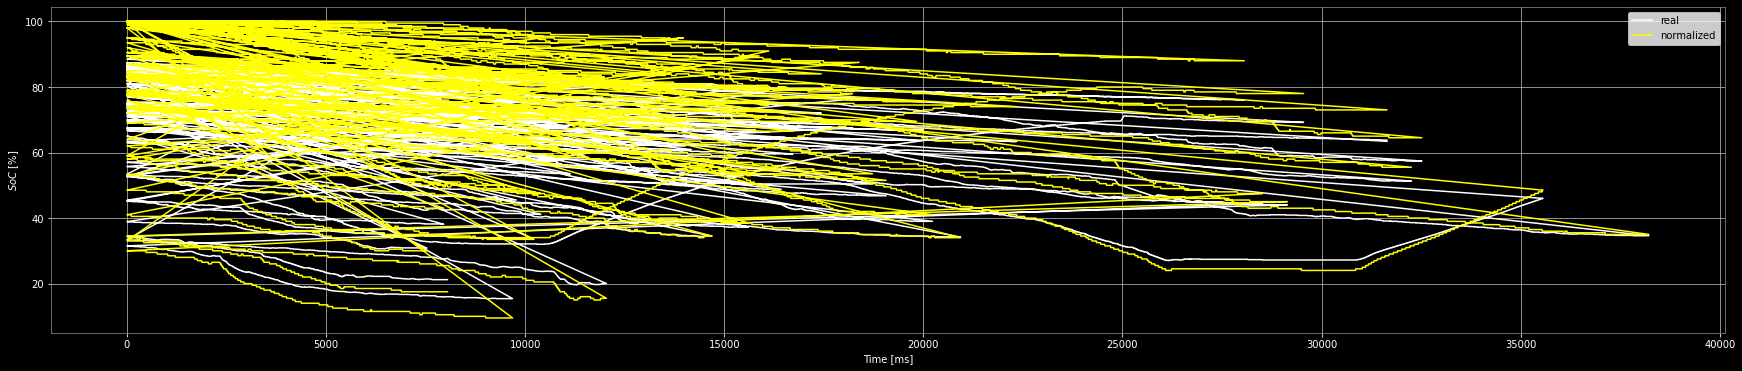

In [7]:
df_soc = df_master[['SoC [%]', 'displayed SoC [%]']].dropna()

# Let us look at battery SoC degradation over vehicle exploitation
plt.figure(figsize=(30, 6), facecolor='black')
ax = plt.axes()
ax.set_facecolor("black")
ax.spines['bottom'].set_color('gray')
ax.spines['top'].set_color('gray')
ax.spines['right'].set_color('gray')
ax.spines['left'].set_color('gray')
ax.tick_params(colors='white', which='both')
plt.grid(True)

plt.plot(df_soc['SoC [%]'], color="white")
plt.plot(df_soc['displayed SoC [%]'], color="yellow")
plt.xlabel('Time [ms]', color='white')
plt.ylabel('$SoC$ [%]', color='white')
plt.legend(['real','normalized'])


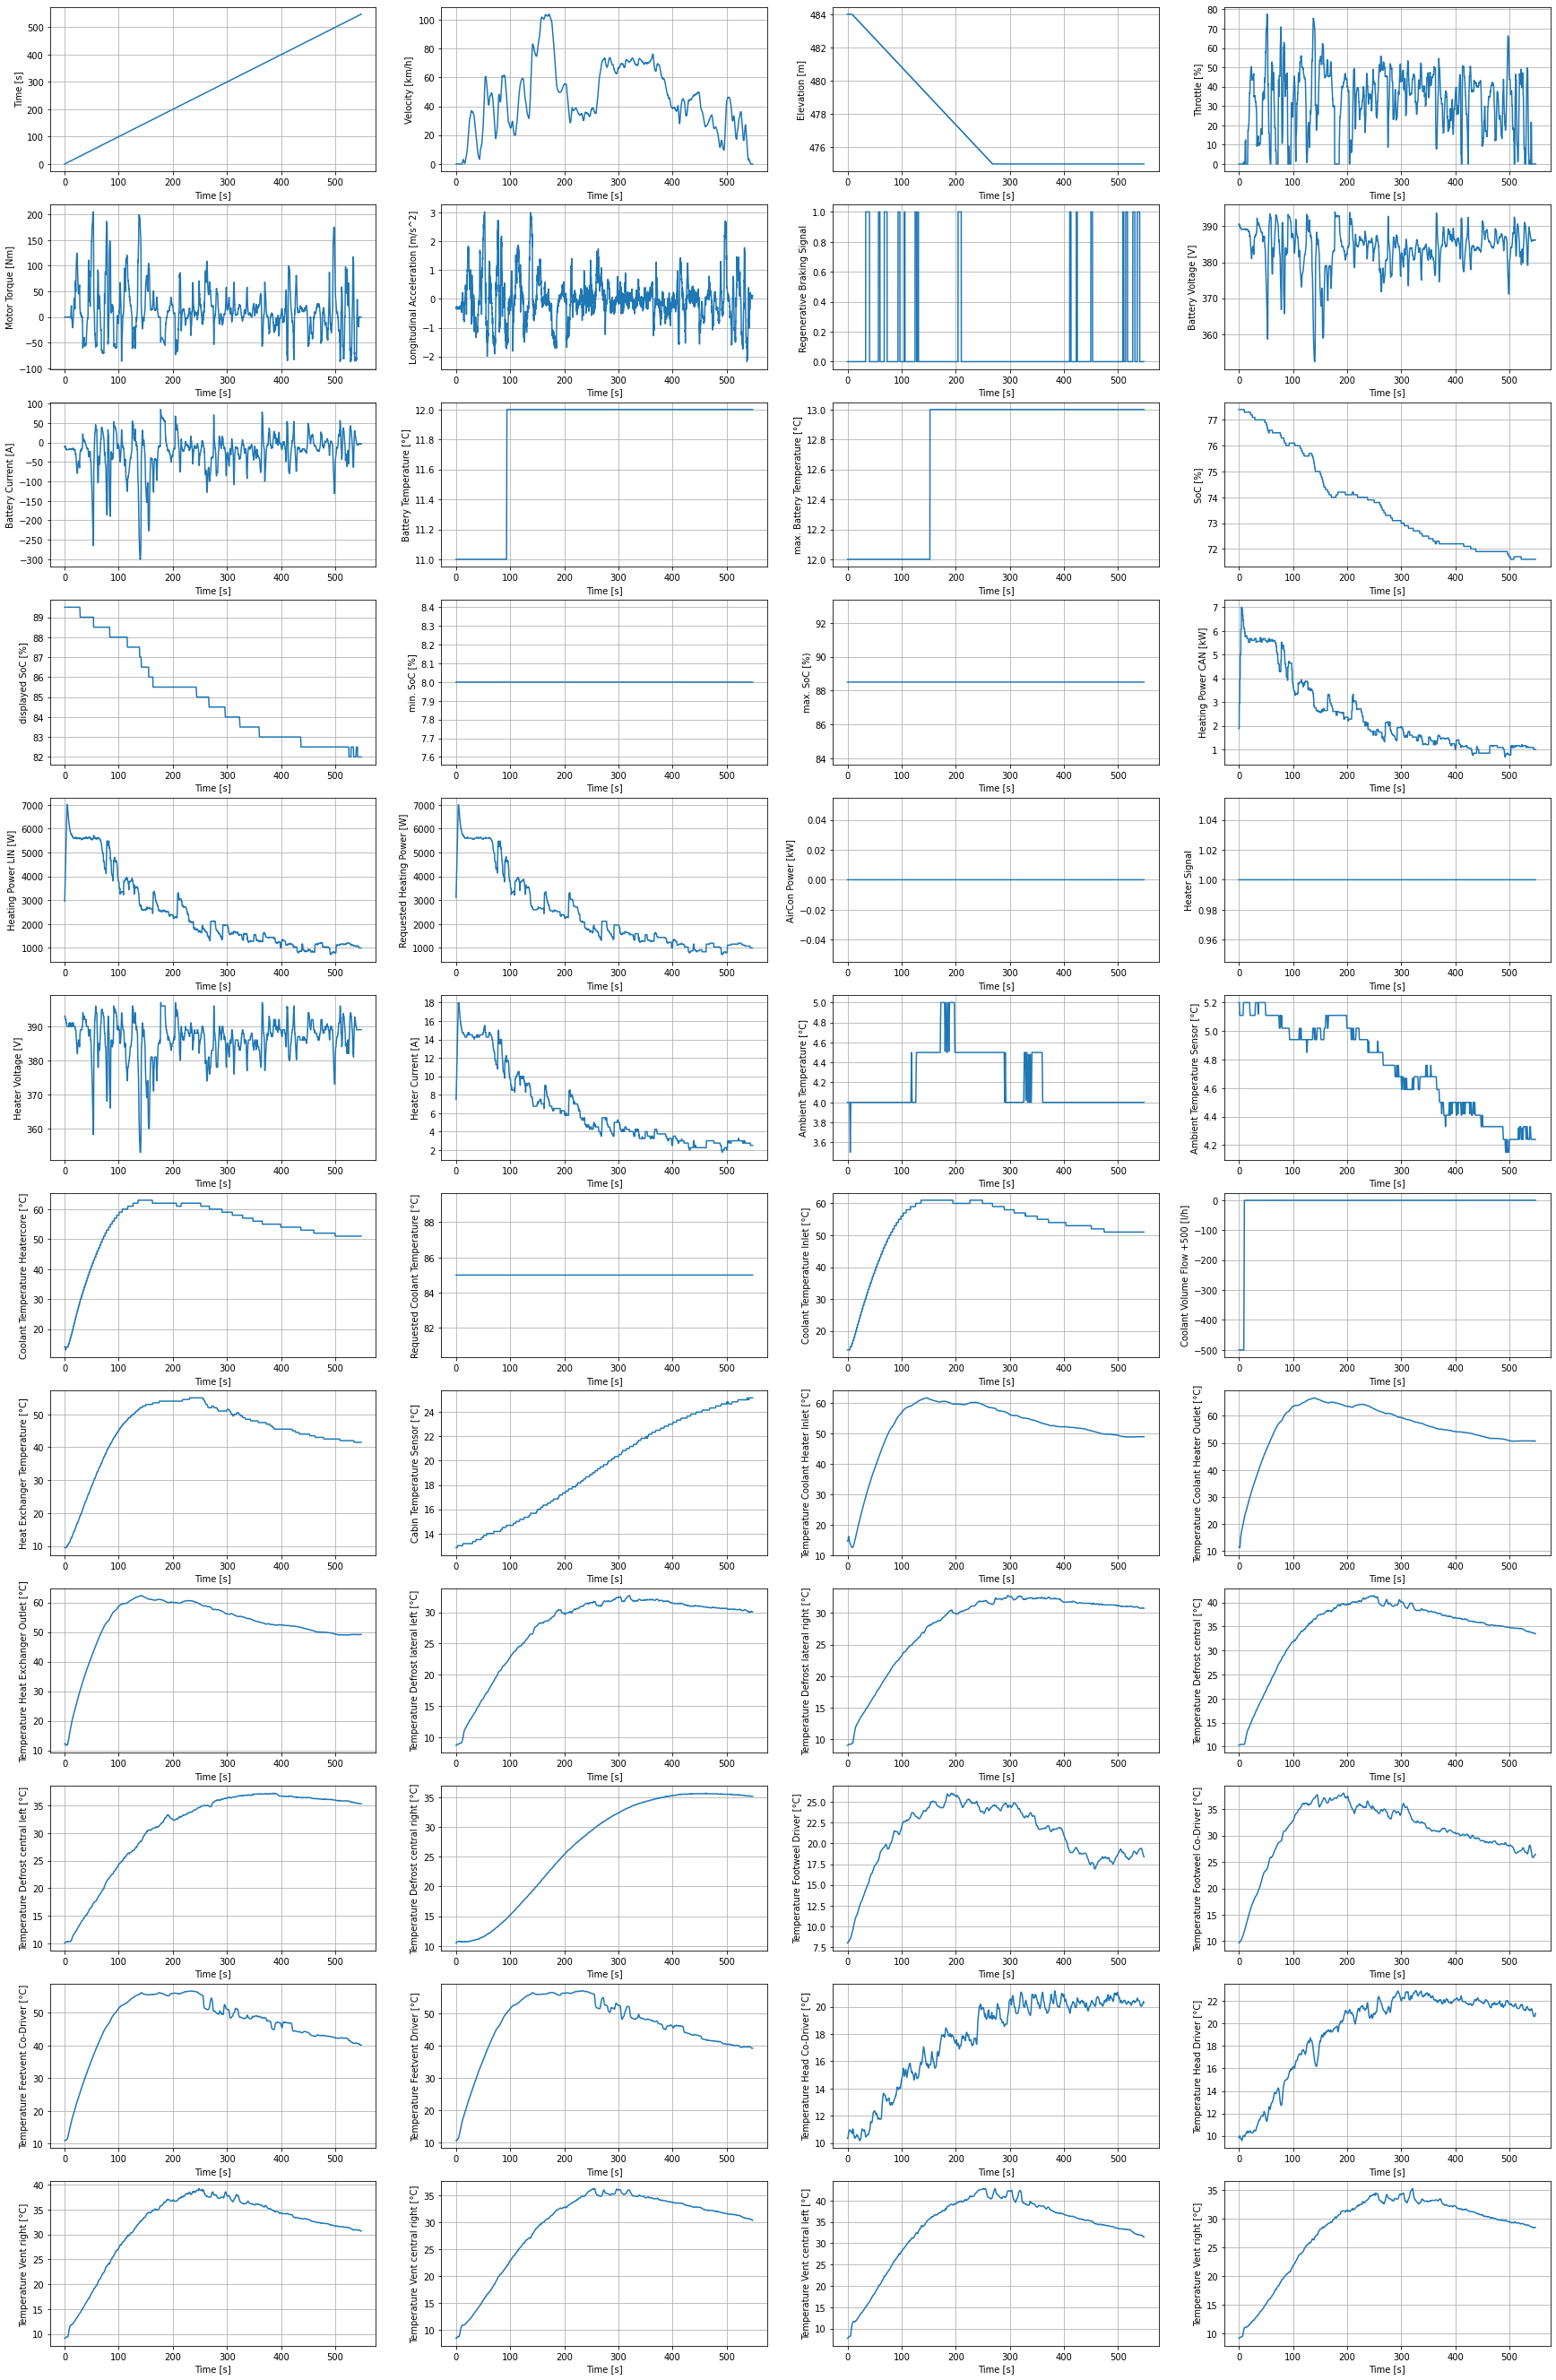

In [8]:
df_trip = pd.read_csv(
    '../input/battery-and-heating-data-in-real-driving-cycles/TripB33.csv',
    sep=';',
    encoding=chardet.detect(open(f'../input/battery-and-heating-data-in-real-driving-cycles/TripA08.csv', 'rb').read())['encoding']
)
# Plot results of a single trips
plot_dataframe_subplots(df_trip, nrows=12, ncols=4, figsize=(30, 48))


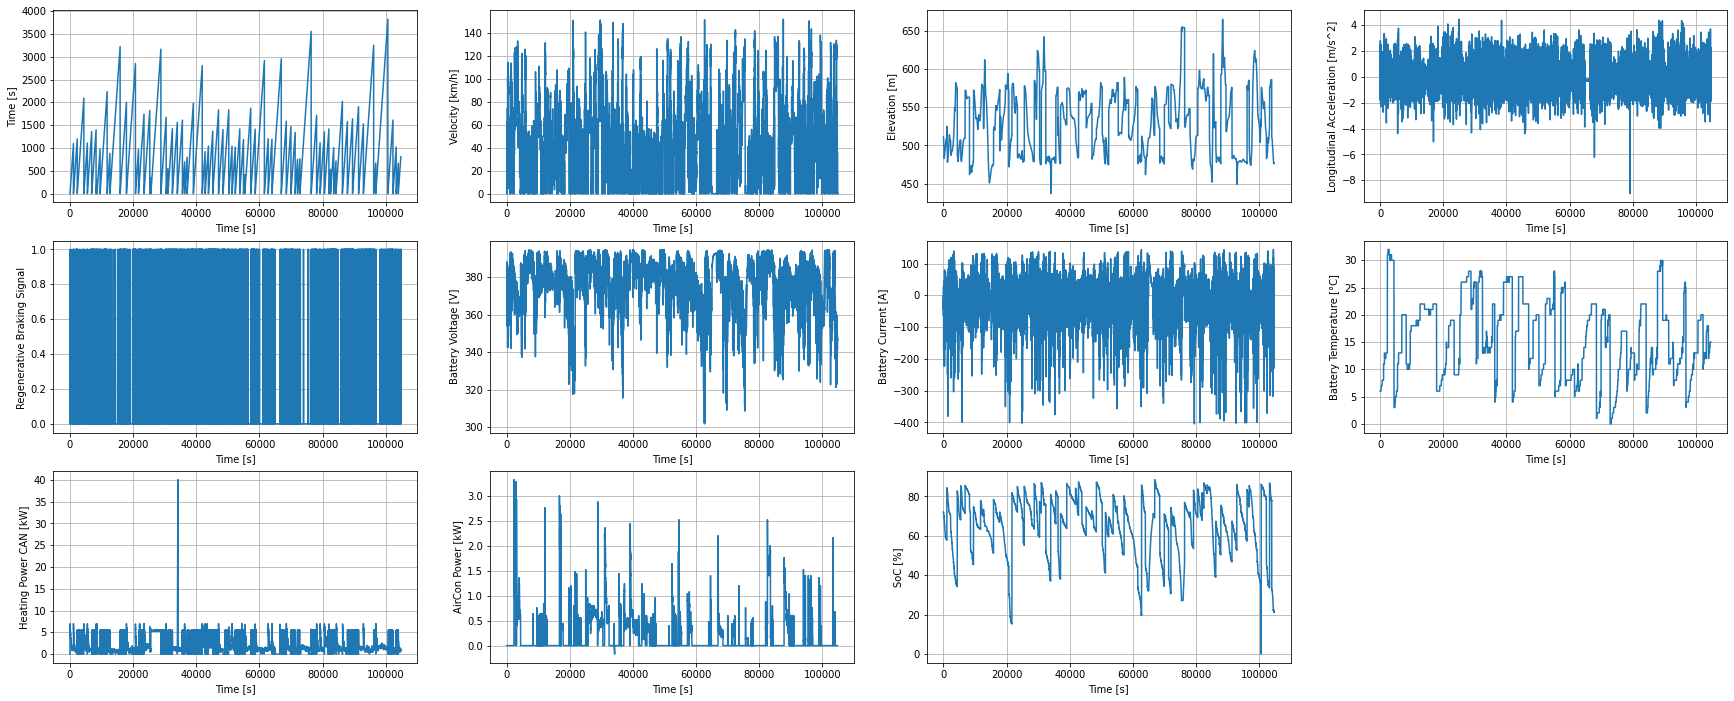

In [9]:
df_x_y = df_master[['Time [s]','Velocity [km/h]','Elevation [m]','Longitudinal Acceleration [m/s^2]','Regenerative Braking Signal ','Battery Voltage [V]',
                    'Battery Current [A]','Battery Temperature [°C]','Heating Power CAN [kW]','AirCon Power [kW]','SoC [%]']].dropna()

plot_dataframe_subplots(df_x_y, nrows=3, ncols=4, figsize=(30, 12))


In [10]:
X = df_x_y.drop(['Time [s]','SoC [%]'], axis=1)
y = df_x_y[['SoC [%]']]
splitter = int(len(X)*0.7)
X_train = X.values[:splitter]
X_test = X.values[splitter:]
y_train = y.values[:splitter]
y_test = y.values[splitter:]
# Check the dataset sizes
X_train.shape, y_train.shape, X_test.shape, y_test.shape[0]


((733299, 9), (733299, 1), (314272, 9), 314272)

In [11]:
import tensorflow as tf
from tensorflow.keras import Sequential, optimizers, losses, layers


**BASE MODEL**

In [12]:
for filename in glob.glob('../input/battery-and-heating-data-in-real-driving-cycles'+'*.csv'):
        df_trip = pd.read_csv(
            TripB35,
            sep=';',
            encoding=chardet.detect(open(filename, 'rb').read())['encoding']
        )



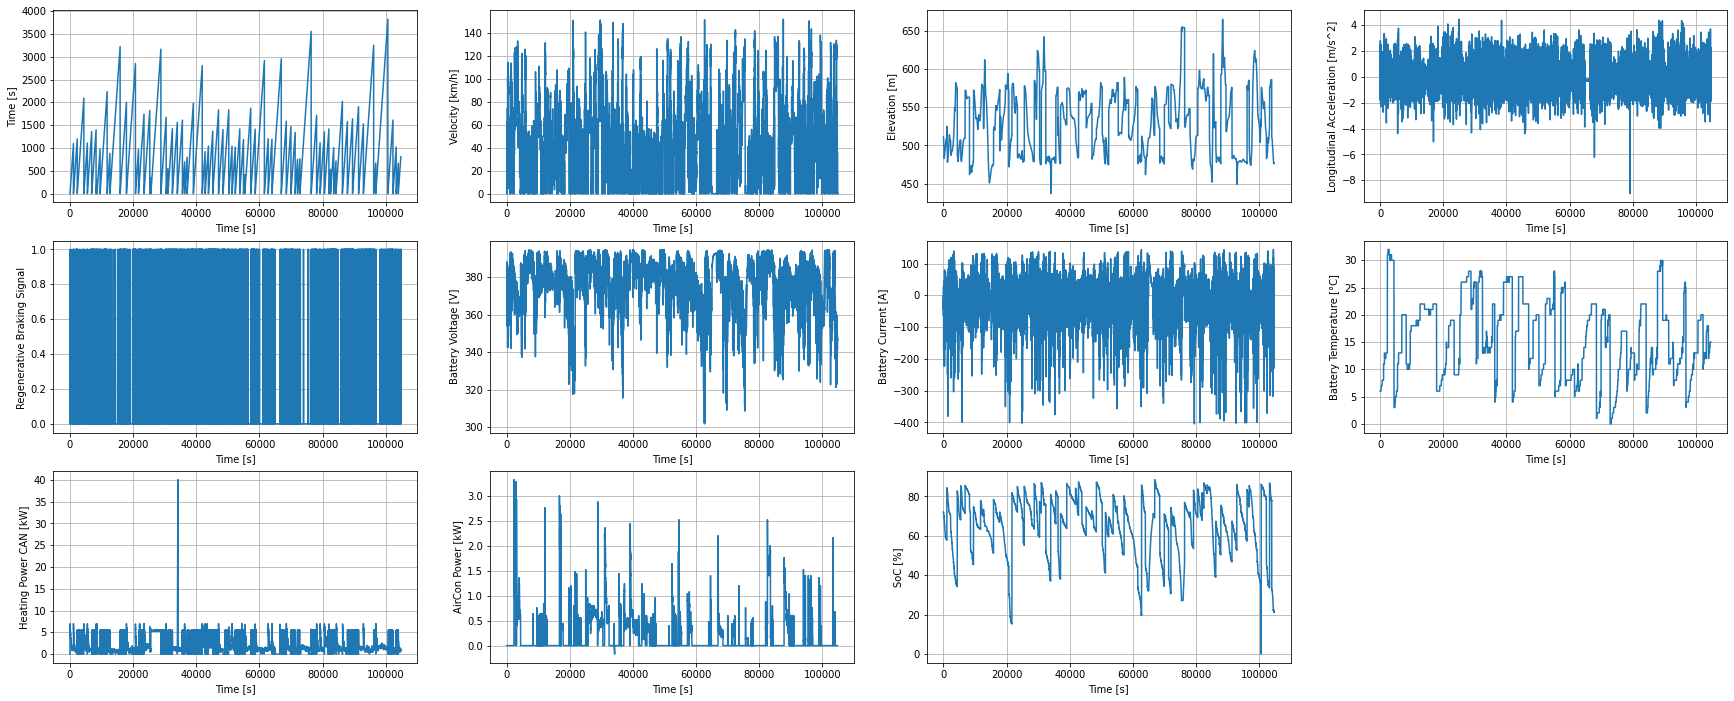

In [13]:
df_try = df_trip[['Time [s]','Velocity [km/h]','Elevation [m]','Longitudinal Acceleration [m/s^2]','Regenerative Braking Signal ','Battery Voltage [V]',
                    'Battery Current [A]','Battery Temperature [°C]','Heating Power CAN [kW]','AirCon Power [kW]','SoC [%]']].dropna()

plot_dataframe_subplots(df_x_y, nrows=3, ncols=4, figsize=(30, 12))

In [14]:
# X = df_try.drop(['Time [s]','SoC [%]'], axis=1)
# y = df_try[['SoC [%]']]
# splitter = int(len(X)*0.7)
# X_train = X.values[:splitter]
# X_test = X.values[splitter:]
# y_train = y.values[:splitter]
# y_test = y.values[splitter:]
# # Check the dataset sizes
# X_train.shape, y_train.shape, X_test.shape, y_test.shape[0]

In [15]:
def plot_comparison(y_test, y_pred, xlabel, ylabel, dark_mode=False, figsize=(30, 6)):
    if dark_mode:
        plt.figure(figsize=figsize, facecolor='black')
        ax = plt.axes()
        ax.set_facecolor("black")
        ax.spines['bottom'].set_color('gray')
        ax.spines['top'].set_color('gray')
        ax.spines['right'].set_color('gray')
        ax.spines['left'].set_color('gray')
        ax.tick_params(colors='white', which='both')
        plt.plot(y_pred, color="yellow")
        plt.plot(y_test, color="white")
        plt.legend(['Predicted', 'Measured'])
        plt.xlabel(xlabel, color='white')
        plt.ylabel(ylabel, color='white')
    else:
        plt.figure(figsize=figsize)
        plt.plot(y_pred)
        plt.plot(y_test)        
        plt.legend(['Predicted', 'Measured'])
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
    plt.grid(True)


def regression_matrics(y_test, y_pred):
    # calculate errors
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    # report error
    print(f'Mean Squared Error: {mse}')
    print(f'Root Mean Square Error: {rmse}')
    print(f'Mean Absolute Error: {mae}')


Linear Regression:
Mean Squared Error: 25.35845895821733
Root Mean Square Error: 5.03571831601186
Mean Absolute Error: 3.4707187507759523


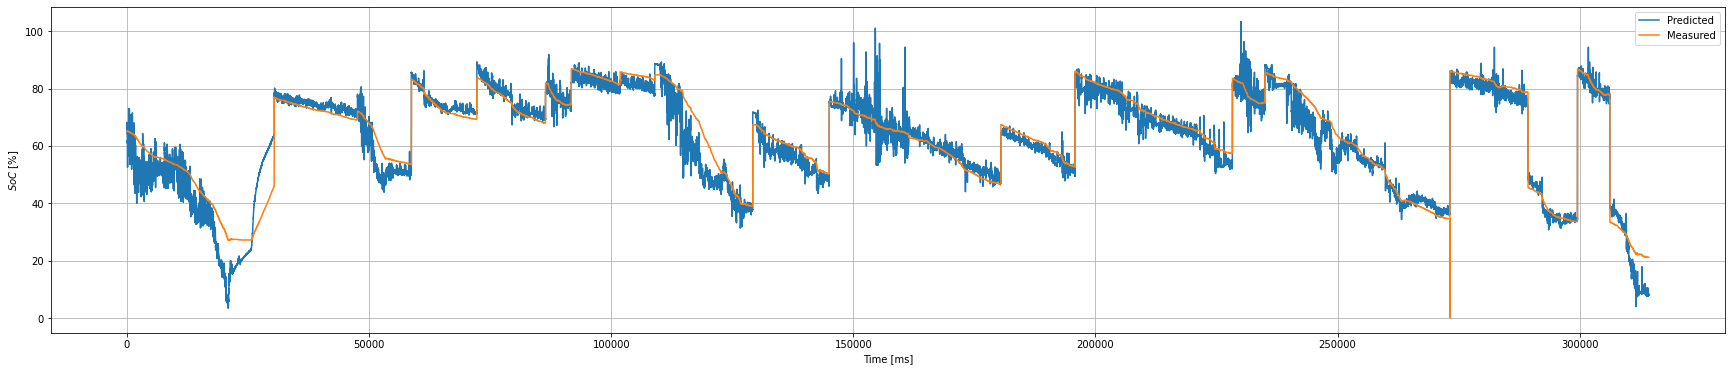

In [16]:
# 1. Create a model
basemodel = LinearRegression()
# 2. Fit the model
basemodel.fit(X_train, y_train)
# 3. Make predicitons with the model
y_pred_lr = basemodel.predict(X_test)
# 4. Evaluate and visualize
print('Linear Regression:')
regression_matrics(y_test, y_pred_lr)
plot_comparison(y_test=y_test, y_pred=y_pred_lr, xlabel="Time [ms]", ylabel="$SoC$ [%]")



**RNN LSTM BASED TENSORFLOW MODEL**

In [36]:
y_train.shape

(417110, 1)

Neural Network:
Mean Squared Error: 36.13072613762144
Root Mean Square Error: 6.010883973062651
Mean Absolute Error: 4.278373696999317


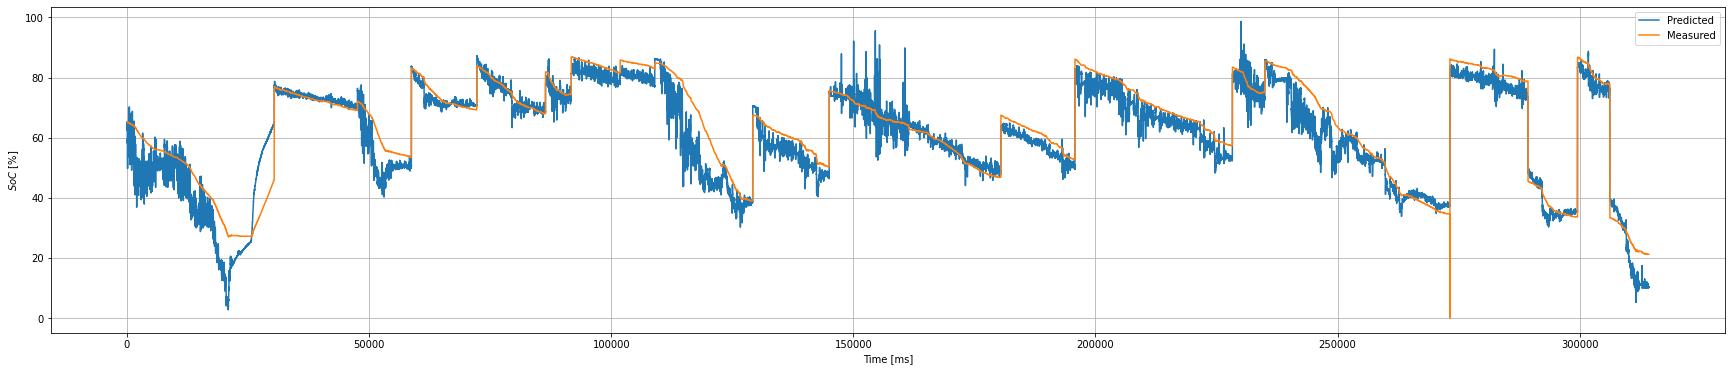

In [21]:
# 1. Create a model
regressor = Sequential([
    layers.Dense(10),
    layers.Dense(10),
    layers.Dense(1),
])
# 2. Compile a model
regressor.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                  loss=losses.mae,
                  metrics=["mae"])
# 3. Fit a model
regressor.fit(X_train, y_train, epochs=10, verbose=0)
# 4. Validate the model
y_pred_nn = regressor.predict(X_test)
# 5. Evaluate and visualize
print('Neural Network:')
regression_matrics(y_test, y_pred_nn)
plot_comparison(y_test=y_test, y_pred=y_pred_nn, xlabel="Time [ms]", ylabel="$SoC$ [%]", dark_mode=False)


In [18]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [45]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
model = Sequential()
model.add(Dense(8, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(1))
model.summary()
model.compile(optimizer=Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08), loss='mean_absolute_error')

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 8)                 192       
_________________________________________________________________
dense_21 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_22 (Dense)             (None, 8)                 72        
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 9         
Total params: 345
Trainable params: 345
Non-trainable params: 0
_________________________________________________________________


In [46]:
model.fit(x=X_train, y=y_train, batch_size=25, epochs=50)



Epoch 1/50
16685/16685 [==============================] - 36s 2ms/step - loss: 3.2703
Epoch 2/50
16685/16685 [==============================] - 36s 2ms/step - loss: 2.5539
Epoch 3/50
16685/16685 [==============================] - 35s 2ms/step - loss: 2.4551
Epoch 4/50
16685/16685 [==============================] - 36s 2ms/step - loss: 2.3328
Epoch 5/50
16685/16685 [==============================] - 36s 2ms/step - loss: 2.2838
Epoch 6/50
16685/16685 [==============================] - 36s 2ms/step - loss: 2.2224
Epoch 7/50
16685/16685 [==============================] - 36s 2ms/step - loss: 2.1895
Epoch 8/50
16685/16685 [==============================] - 36s 2ms/step - loss: 2.1555
Epoch 9/50
16685/16685 [==============================] - 36s 2ms/step - loss: 2.1098
Epoch 10/50
16685/16685 [==============================] - 36s 2ms/step - loss: 2.0450
Epoch 11/50
16685/16685 [==============================] - 36s 2ms/step - loss: 1.9903
Epoch 12/50
16685/16685 [===========================

In [47]:
pred = model.predict(X_test)


In [53]:
rms_error = np.sqrt(mean_squared_error(y_test, pred))
print(rms_error)

4.968187627843511


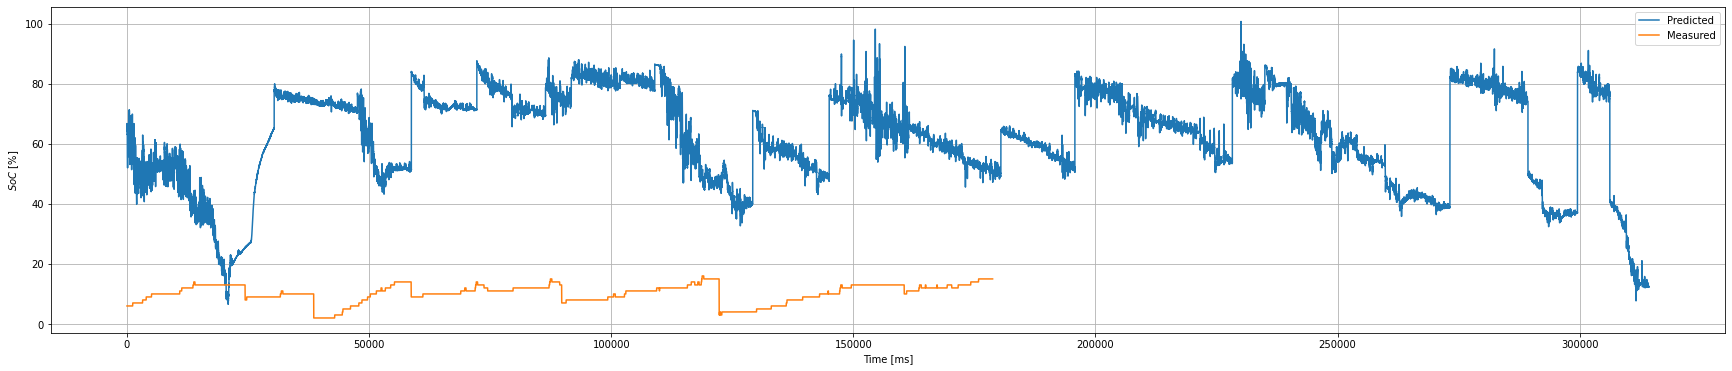

In [54]:
plot_comparison(y_test=y_test, y_pred=y_pred_nn, xlabel="Time [ms]", ylabel="$SoC$ [%]", dark_mode=False)


Neural Network:
Mean Squared Error: 27.035215622844007
Root Mean Square Error: 5.199539943383838
Mean Absolute Error: 3.6460951355514886


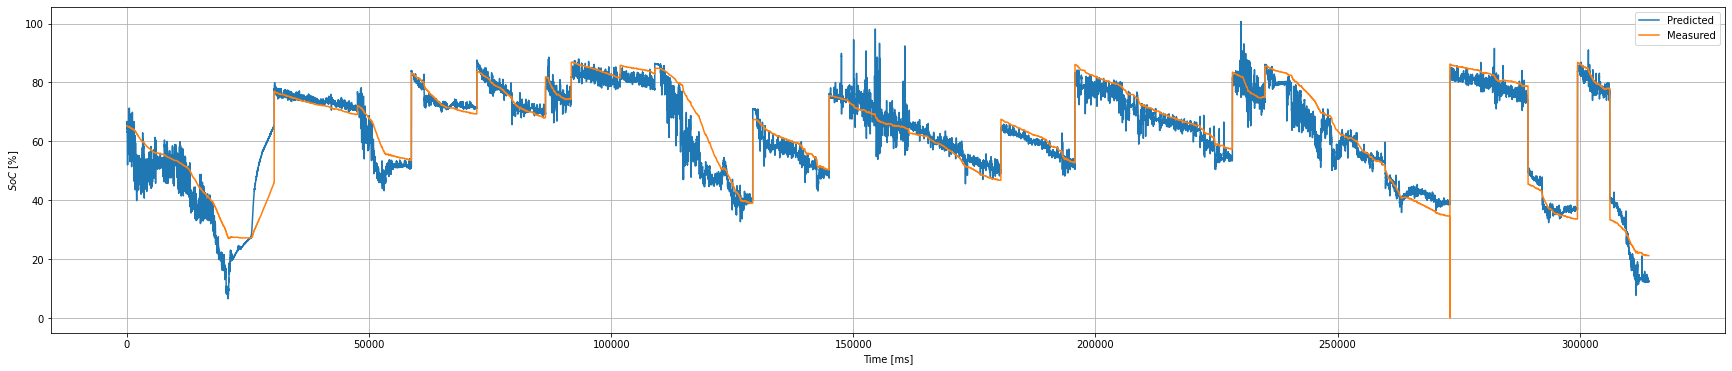

In [22]:
regressor = Sequential([
    layers.Dense(10),
    layers.Dense(100),
    layers.Dense(100),
    layers.Dense(1),
])
regressor.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                  loss=losses.mae,
                  metrics=["mae"])
regressor.fit(X_train, y_train, epochs=20, verbose=0)
y_pred_nn = regressor.predict(X_test)
print('Neural Network:')
regression_matrics(y_test, y_pred_nn)
plot_comparison(y_test=y_test, y_pred=y_pred_nn, xlabel="Time [ms]", ylabel="$SoC$ [%]", dark_mode=False)


**TEMPERATURE**

In [23]:
df_x_y = df_master[['Elevation [m]','Motor Torque [Nm]','Battery Voltage [V]','Battery Current [A]','SoC [%]','Heating Power CAN [kW]', 'Heating Power LIN [W]',
                    'Requested Heating Power [W]', 'AirCon Power [kW]','Heater Signal', 'Heater Current [A]','Ambient Temperature [°C]','Coolant Temperature Heatercore [°C]',
                    'Coolant Temperature Inlet [°C]','Heat Exchanger Temperature [°C]','Cabin Temperature Sensor [°C]','Temperature Coolant Heater Inlet [°C]',
                    'Temperature Coolant Heater Outlet [°C]','Temperature Heat Exchanger Outlet [°C]','Temperature Footweel Driver [°C]','Temperature Footweel Co-Driver [°C]',
                    'Temperature Head Co-Driver [°C]','Temperature Head Driver [°C]','Battery Temperature [°C]']].dropna()


In [24]:
# Create and split train and test datasets
X = df_x_y.drop(['Battery Temperature [°C]'], axis=1)
y = df_x_y[['Battery Temperature [°C]']]
splitter = int(len(X)*0.7)
X_train = X.values[:splitter]
X_test = X.values[splitter:]
y_train = y.values[:splitter]
y_test = y.values[splitter:]
# Check the dataset sizes
X_train.shape[0] == y_train.shape[0], X_test.shape[0] == y_test.shape[0],\
    X_train.shape[1] == X_test.shape[1], y_train.shape[1] == y_test.shape[1]


(True, True, True, True)

Linear Regression:
Mean Squared Error: 10.361332501086707
Root Mean Square Error: 3.2189023752028745
Mean Absolute Error: 2.596168015765212


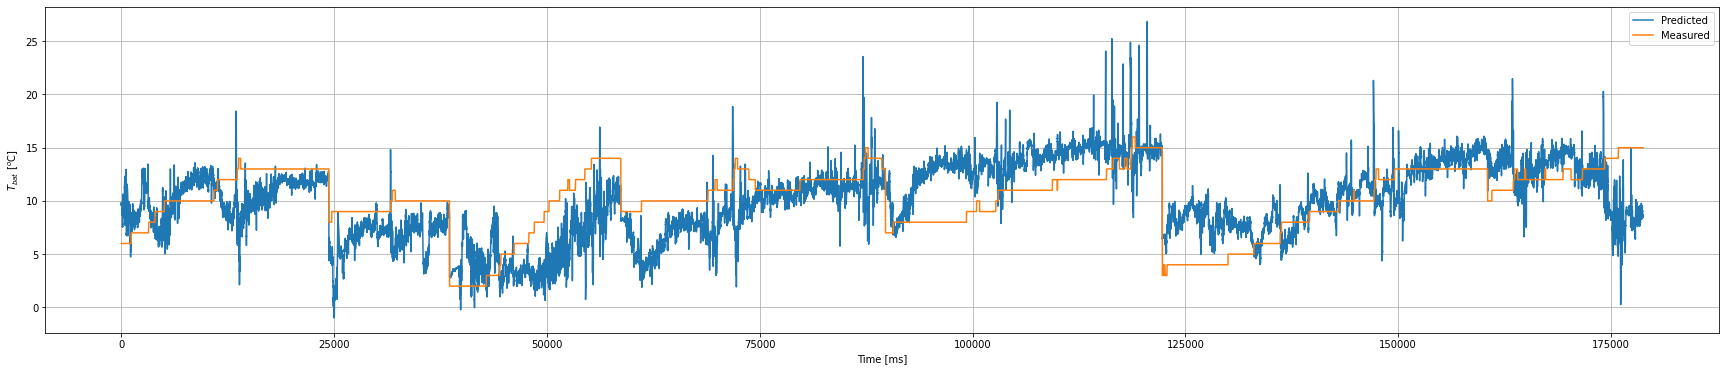

In [26]:
# 1. Create a model
regressor = LinearRegression()
# 2. Fit the model
regressor.fit(X_train, y_train)
# 3. Make predicitons with the model
y_pred_lr = regressor.predict(X_test)
# 4. Evaluate and visualize
print('Linear Regression:')
regression_matrics(y_test, y_pred_lr)
plot_comparison(y_test=y_test, y_pred=y_pred_lr, xlabel="Time [ms]", ylabel='$T_{bat}$ [$^o$C]', dark_mode=False)

Neural Network:
Mean Squared Error: 15.89999137898286
Root Mean Square Error: 3.987479326464635
Mean Absolute Error: 3.2340238333871025


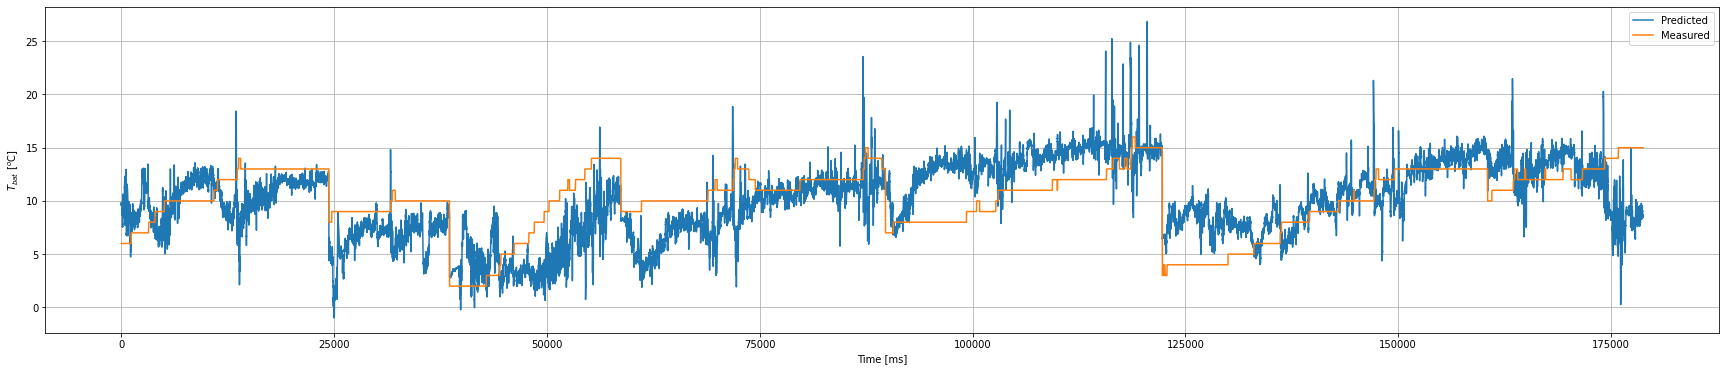

In [55]:
# 1. Create a model
regressor = Sequential([
    layers.Dense(10),
    layers.Dense(10),
    layers.Dense(1),
])
# 2. Compile a model
regressor.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                  loss=losses.mae,
                  metrics=["mae"])
# 3. Fit a model
regressor.fit(X_train, y_train, epochs=10, verbose=0)
# 4. Validate the model
y_pred_nn = regressor.predict(X_test)
# 5. Evaluate and visualize
print('Neural Network:')
regression_matrics(y_test, y_pred_nn)
plot_comparison(y_test=y_test, y_pred=y_pred_lr, xlabel="Time [ms]", ylabel='$T_{bat}$ [$^o$C]', dark_mode=False)